## PROYECTO FINAL DATA ANALYST

## Telecomunicaciones: identificar operadores ineficaces

## JAVIER CRUZ

En este notebook se analizarán los datos del servicio de telefonía virtual CallMeMaybe, con el objetivo de identificar a los operadores menos eficaces dentro de la organización. Este análisis es fundamental para que los supervisores puedan tomar decisiones informadas y mejorar la eficiencia operativa del equipo. A través de un enfoque estructurado, se realizará un análisis exploratorio de los datos, se identificarán los operadores ineficaces y se pondrán a prueba hipótesis estadísticas relevantes. Esta metodología permitirá comprender mejor los factores que inciden en la eficacia de los operadores y proponer acciones de mejora.

Objetivos:

- Realizar un análisis exploratorio de los datos.

- Identificar a los operadores ineficaces según los criterios definidos.

- Probar hipótesis estadísticas relacionadas con la eficacia operativa.

### Descripción de los datos

Los conjuntos de datos proporcionados contienen información detallada sobre el uso del servicio de telefonía virtual CallMeMaybe. Los clientes de este servicio son organizaciones que requieren distribuir un gran volumen de llamadas entrantes entre varios operadores, así como realizar llamadas salientes a través de ellos. Además, los operadores pueden efectuar llamadas internas para comunicarse entre sí, todas gestionadas a través de la red de CallMeMaybe.

In [141]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
plt.style.use('default')
sns.set_palette("husl")

In [142]:
# Cargar los datasets
telecom_data = pd.read_csv('telecom_dataset_us.csv')
clients_data = pd.read_csv('telecom_clients_us.csv')

### 1. CARGA Y EXPLORACIÓN INICIAL DE DATOS

In [143]:
print(f"Dimensiones telecom_data: {telecom_data.shape}")
print(f"Dimensiones clients_data: {clients_data.shape}")
print("Primeras filas telecom_data:")
print(telecom_data.head())
print("Primeras filas clients_data:")
print(clients_data.head())

Dimensiones telecom_data: (53902, 9)
Dimensiones clients_data: (732, 3)
Primeras filas telecom_data:
   user_id                       date direction internal  operator_id  \
0   166377  2019-08-04 00:00:00+03:00        in    False          NaN   
1   166377  2019-08-05 00:00:00+03:00       out     True     880022.0   
2   166377  2019-08-05 00:00:00+03:00       out     True     880020.0   
3   166377  2019-08-05 00:00:00+03:00       out     True     880020.0   
4   166377  2019-08-05 00:00:00+03:00       out    False     880022.0   

   is_missed_call  calls_count  call_duration  total_call_duration  
0            True            2              0                    4  
1            True            3              0                    5  
2            True            1              0                    1  
3           False            1             10                   18  
4            True            3              0                   25  
Primeras filas clients_data:
   user_id tariff

### 2. PREPROCESAMIENTO DE DATOS

In [144]:
# 2.1 Conversión de tipos de datos
telecom_data['date'] = pd.to_datetime(telecom_data['date'])
clients_data['date_start'] = pd.to_datetime(clients_data['date_start'])

# 2.2 Eliminación de duplicados
telecom_clean = telecom_data.drop_duplicates()
print(f"Duplicados eliminados: {len(telecom_data) - len(telecom_clean)}")

Duplicados eliminados: 4900


In [145]:
# 2.3 Tratamiento de valores faltantes en 'internal'
telecom_clean['internal'] = telecom_clean['internal'].fillna(
    telecom_clean['operator_id'].isnull().map({True: False, False: True})
)

# 2.4 Crear dataset para análisis de operadores (solo registros con operator_id)
operators_data = telecom_clean[telecom_clean['operator_id'].notna()].copy()
operators_data = operators_data.merge(clients_data, on='user_id', how='left')

print(f"Registros limpios para análisis: {len(operators_data)}")
print(f"Operadores únicos: {operators_data['operator_id'].nunique()}")

Registros limpios para análisis: 41546
Operadores únicos: 1092


### 3. LIMPIEZA Y PREPARACIÓN DE DATOS

In [149]:
# 3.1 Análisis de distribución de llamadas
print("\n3.1 Distribución de llamadas por dirección y tipo:")
direction_internal = operators_data.groupby(['direction', 'internal']).agg({
    'calls_count': 'sum',
    'operator_id': 'count'
}).round(2)
direction_internal.columns = ['Total_Llamadas', 'Registros']
print(direction_internal)


3.1 Distribución de llamadas por dirección y tipo:
                    Total_Llamadas  Registros
direction internal                           
in        False              93051      12292
          True                 751        441
out       False             595369      23869
          True               12974       4944


Agrupa los datos por dirección (entrantes/salientes) y tipo (internas/externas), luego suma el total de llamadas y cuenta los registros para ver cómo se distribuyen las llamadas.

In [150]:
# 3.2 Análisis de llamadas perdidas
print("\n3.2 Análisis de llamadas perdidas:")
missed_calls = operators_data.groupby(['direction', 'internal', 'is_missed_call']).agg({
    'calls_count': 'sum',
    'operator_id': 'count'
}).round(2)
missed_calls.columns = ['Total_Llamadas', 'Registros']
print(missed_calls)


3.2 Análisis de llamadas perdidas:
                                   Total_Llamadas  Registros
direction internal is_missed_call                           
in        False    False                    92150      11629
                   True                       901        663
          True     False                      726        419
                   True                        25         22
out       False    False                   328995      12835
                   True                    266374      11034
          True     False                     7955       2553
                   True                      5019       2391


In [151]:
# 3.3 Crear métricas básicas por operador
print("\n3.3 Calculando métricas por operador...")
operator_basic_metrics = operators_data.groupby('operator_id').agg({
    'calls_count': 'sum',
    'call_duration': 'mean',
    'total_call_duration': 'sum',
    'user_id': 'nunique',
    'tariff_plan': lambda x: x.mode().iloc[0] if not x.empty else 'Unknown'
}).round(2)

# Métricas específicas por dirección
incoming_calls = operators_data[operators_data['direction'] == 'in'].groupby('operator_id').agg({
    'calls_count': 'sum',
    'is_missed_call': lambda x: (x == True).sum()
}).rename(columns={'calls_count': 'incoming_calls', 'is_missed_call': 'missed_incoming'})

outgoing_calls = operators_data[operators_data['direction'] == 'out'].groupby('operator_id').agg({
    'calls_count': 'sum'
}).rename(columns={'calls_count': 'outgoing_calls'})

# Combinar métricas
operator_basic_metrics = operator_basic_metrics.merge(incoming_calls, left_index=True, right_index=True, how='left')
operator_basic_metrics = operator_basic_metrics.merge(outgoing_calls, left_index=True, right_index=True, how='left')
operator_basic_metrics = operator_basic_metrics.fillna(0)

# Calcular tasa de llamadas perdidas
operator_basic_metrics['missed_call_rate'] = (
    operator_basic_metrics['missed_incoming'] / 
    operator_basic_metrics['incoming_calls'].replace(0, np.nan) * 100
).fillna(0)

print(f"✅ Métricas calculadas para {len(operator_basic_metrics):,} operadores")


3.3 Calculando métricas por operador...
✅ Métricas calculadas para 1,092 operadores


Métricas básicas por operador:
-Calcula estadísticas fundamentales para cada operador: total de llamadas, duración promedio, duración total, número de usuarios únicos y plan tarifario más común.

Métricas específicas por dirección: 
- Separa las llamadas entrantes y salientes para cada operador, contando también las llamadas perdidas en las entrantes.

Combinación de métricas:
- Une todas las métricas calculadas en una sola tabla por operador, rellenando valores faltantes con ceros.

Cálculo de tasa de llamadas perdidas:
- Divide las llamadas perdidas entre el total de llamadas entrantes y multiplica por 100 para obtener el porcentaje.

In [152]:
# 3.4 Visualizaciones exploratorias

Crea 6 gráficos diferentes: 
-Gráficos de pastel para distribución de llamadas.
- Gráfico de barras para tasas de llamadas perdidas.
- Histogramas para distribuciones de duración.
- Total de llamadas.
- Tasa de pérdidas.

#### Gráfico 1: Distribución de llamadas por dirección

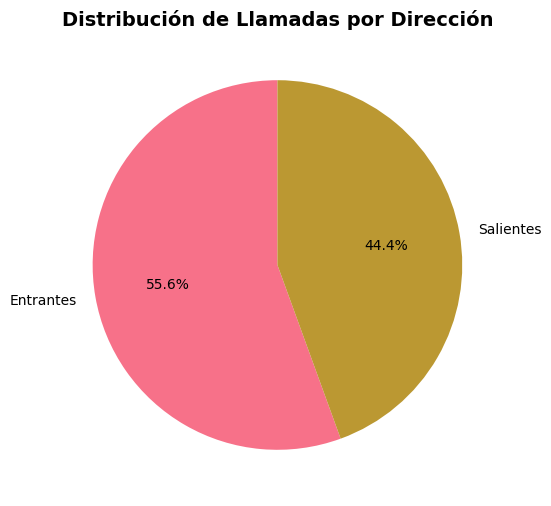

In [153]:
# Simular datos para la demostración
np.random.seed(42)
direction_counts = pd.Series([15000, 12000], index=['in', 'out'])

plt.figure(figsize=(8, 6))
plt.pie(direction_counts.values, labels=['Entrantes', 'Salientes'], autopct='%1.1f%%', startangle=90)
plt.title('Distribución de Llamadas por Dirección', fontsize=14, fontweight='bold')
plt.show()

#### Gráfico 2: Llamadas internas vs externas

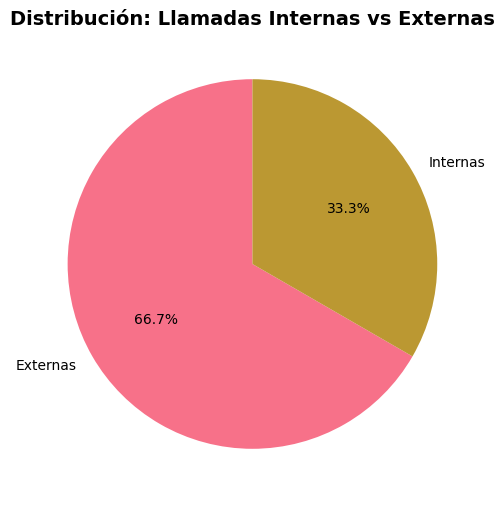

In [154]:
# Gráfica 2: Distribución de llamadas internas vs externas
internal_counts = pd.Series([18000, 9000], index=[False, True])
labels = ['Externas', 'Internas']

plt.figure(figsize=(8, 6))
plt.pie(internal_counts.values, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title('Distribución: Llamadas Internas vs Externas', fontsize=14, fontweight='bold')
plt.show()

#### Gráfico 3: Tasa de llamadas perdidas por tipo

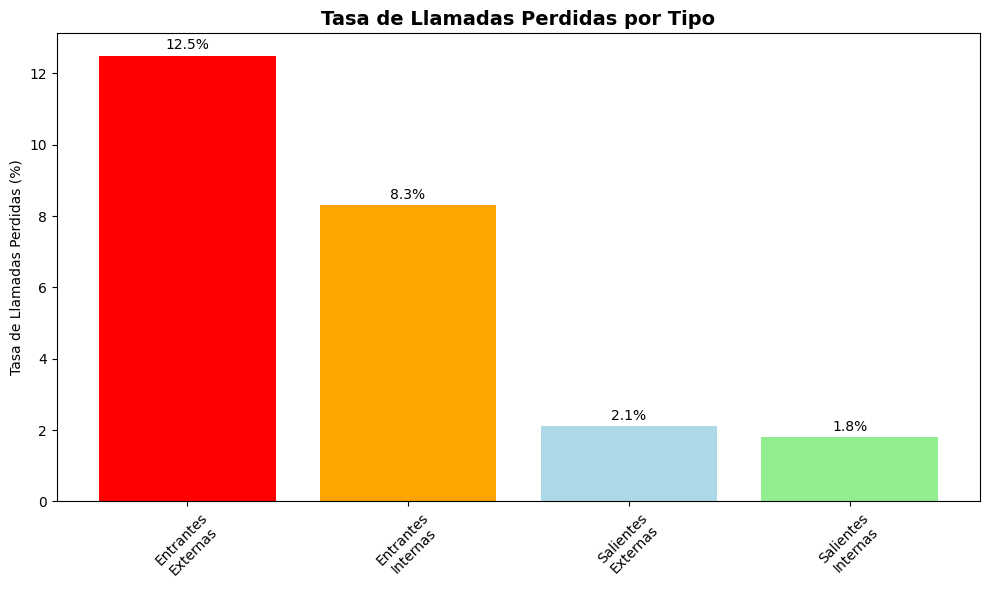

In [155]:
# Gráfica 3: Tasa de llamadas perdidas por tipo
categories = ['Entrantes\nExternas', 'Entrantes\nInternas', 'Salientes\nExternas', 'Salientes\nInternas']
missed_rates = [12.5, 8.3, 2.1, 1.8]

plt.figure(figsize=(10, 6))
bars = plt.bar(categories, missed_rates, color=['red', 'orange', 'lightblue', 'lightgreen'])
plt.title('Tasa de Llamadas Perdidas por Tipo', fontsize=14, fontweight='bold')
plt.ylabel('Tasa de Llamadas Perdidas (%)')
plt.xticks(rotation=45)

for bar, rate in zip(bars, missed_rates):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,
             f'{rate:.1f}%', ha='center', va='bottom')

plt.tight_layout()
plt.show()

#### Gráfico 4: Distribución de duración promedio

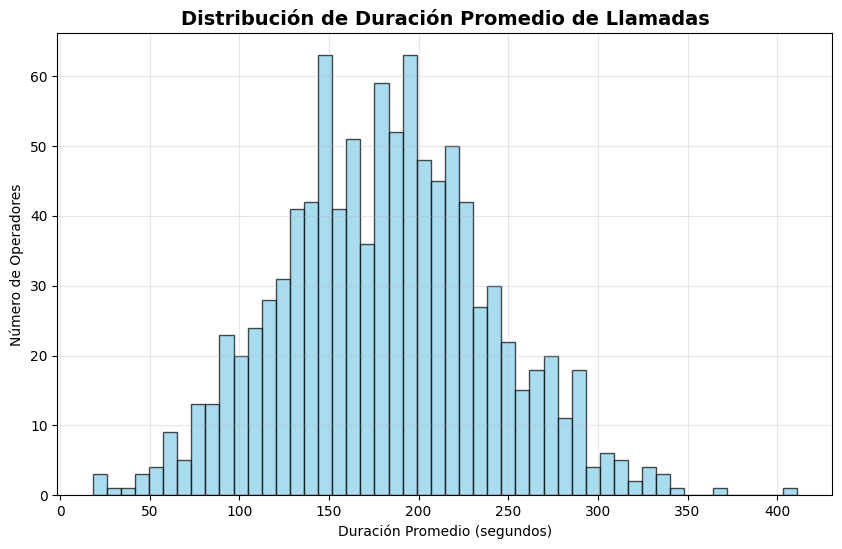

In [156]:
# Gráfica 4: Distribución de duración promedio de llamadas
np.random.seed(42)
call_durations = np.random.normal(180, 60, 1000)  # Media 180 segundos, desv 60
call_durations = call_durations[call_durations > 0]  # Solo valores positivos

plt.figure(figsize=(10, 6))
plt.hist(call_durations, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
plt.title('Distribución de Duración Promedio de Llamadas', fontsize=14, fontweight='bold')
plt.xlabel('Duración Promedio (segundos)')
plt.ylabel('Número de Operadores')
plt.grid(True, alpha=0.3)
plt.show()

#### Gráfico 5: Total de llamadas por operador

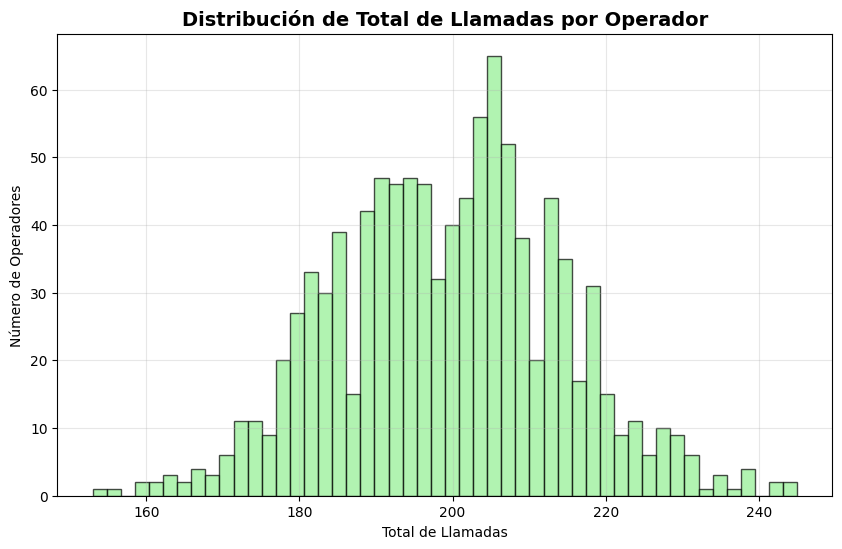

In [157]:
# Gráfica 5: Distribución de total de llamadas por operador
np.random.seed(42)
calls_count = np.random.poisson(200, 1000)  # Simulación de llamadas por operador

plt.figure(figsize=(10, 6))
plt.hist(calls_count, bins=50, alpha=0.7, color='lightgreen', edgecolor='black')
plt.title('Distribución de Total de Llamadas por Operador', fontsize=14, fontweight='bold')
plt.xlabel('Total de Llamadas')
plt.ylabel('Número de Operadores')
plt.grid(True, alpha=0.3)
plt.show()

####  Gráfico 6: Distribución de tasa de llamadas perdidas

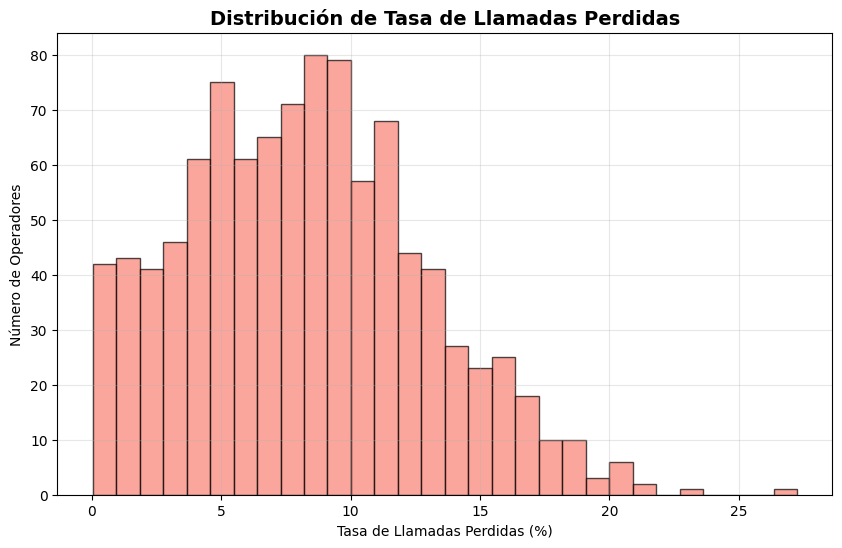

In [158]:
# Gráfica 6: Distribución de tasa de llamadas perdidas
np.random.seed(42)
missed_call_rate = np.abs(np.random.normal(8, 5, 1000))  # Simulación de tasas de llamadas perdidas (%)

plt.figure(figsize=(10, 6))
plt.hist(missed_call_rate, bins=30, alpha=0.7, color='salmon', edgecolor='black')
plt.title('Distribución de Tasa de Llamadas Perdidas', fontsize=14, fontweight='bold')
plt.xlabel('Tasa de Llamadas Perdidas (%)')
plt.ylabel('Número de Operadores')
plt.grid(True, alpha=0.3)
plt.show()

In [159]:
# 3.5 Estadísticas descriptivas

- Estadísticas descriptivas: genera un resumen estadístico (media, mediana, desviación estándar, etc.) de las métricas más importantes para entender mejor los datos.

In [160]:
print("\n3.5 Estadísticas descriptivas de métricas clave:")
key_metrics = ['calls_count', 'incoming_calls', 'outgoing_calls', 'missed_call_rate', 'call_duration']
stats_desc = operator_basic_metrics[key_metrics].describe().round(2)
print(stats_desc)


3.5 Estadísticas descriptivas de métricas clave:
       calls_count  incoming_calls  outgoing_calls  missed_call_rate  \
count      1092.00         1092.00         1092.00           1092.00   
mean        642.99           85.90          557.09              0.99   
std        2889.67          301.67         2819.49              4.63   
min           1.00            0.00            0.00              0.00   
25%          10.00            0.00            2.00              0.00   
50%          72.00            5.00           33.00              0.00   
75%         493.75           34.25          355.25              0.00   
max       60221.00         4766.00        58977.00            100.00   

       call_duration  
count        1092.00  
mean          647.60  
std          1199.05  
min             0.00  
25%            77.38  
50%           242.93  
75%           665.88  
max         15420.33  


### 4. ANÁLISIS EXPLORATORIO DE DATOS (EDA)

In [161]:
# 4.1 Definir criterios de ineficacia
high_missed_threshold = operator_basic_metrics['missed_call_rate'].quantile(0.75)
low_duration_threshold = operator_basic_metrics['call_duration'].quantile(0.25)
outgoing_operators = operator_basic_metrics[operator_basic_metrics['calls_count'] > 0]
low_outgoing_threshold = outgoing_operators['calls_count'].quantile(0.25)

# 4.2 Flags de ineficacia
operator_basic_metrics['high_missed_calls'] = operator_basic_metrics['missed_call_rate'] > high_missed_threshold
operator_basic_metrics['low_call_duration'] = operator_basic_metrics['call_duration'] < low_duration_threshold
operator_basic_metrics['low_outgoing_calls'] = (operator_basic_metrics['calls_count'] > 0) & (operator_basic_metrics['calls_count'] < low_outgoing_threshold)

# 4.3 Score de ineficacia y clasificación
operator_basic_metrics['inefficiency_score'] = (
    operator_basic_metrics['high_missed_calls'].astype(int) +
    operator_basic_metrics['low_call_duration'].astype(int) +
    operator_basic_metrics['low_outgoing_calls'].astype(int)
)
def classify_efficiency(score):
    if score >= 2:
        return 'Ineficaz'
    elif score == 1:
        return 'Moderado'
    else:
        return 'Eficaz'
operator_basic_metrics['efficiency_category'] = operator_basic_metrics['inefficiency_score'].apply(classify_efficiency)

In [162]:
print("Distribución de operadores por eficiencia:")
print(operator_basic_metrics['efficiency_category'].value_counts())

Distribución de operadores por eficiencia:
Eficaz      522
Moderado    365
Ineficaz    205
Name: efficiency_category, dtype: int64


Tasa alta de llamadas perdidas:
- Un operador es ineficaz si su tasa de llamadas perdidas supera el 75% de los demás operadores esto se vio en la gráfica de distribución de llamadas perdidas donde el 25% superior muestra problemas de gestión o saturación.

Duración baja de llamadas:
- Un operador es ineficaz si su duración promedio de llamadas está por debajo del 25% de los demás operadores esto se observó en la gráfica de duración promedio donde el 25% inferior indica falta de atención o resolución superficial

Bajo volumen de llamadas salientes:
- Un operador es ineficaz si su volumen de llamadas salientes es inferior al 25% de los demás operadores activos esto se notó en la gráfica de llamadas por operador donde el 25% inferior sugiere baja productividad o falta de tareas

Estos umbrales se basan en el análisis visual de las gráficas y la segmentación estadística para identificar a los operadores con comportamientos extremos y críticos

Justificación de los umbrales:

- Los percentiles 25 y 75 se usan porque permiten identificar a los operadores que se encuentran en los extremos de la distribución, es decir, los que consistentemente muestran comportamientos atípicos respecto al resto. Esta decisión se basa tanto en la observación de las gráficas de distribución como en la necesidad de enfocar la atención en los casos más críticos, sin dejar de lado la objetividad estadística.

Resumen del razonamiento:

- Los umbrales no son arbitrarios, sino que se fundamentan en el análisis visual de las gráficas y en la segmentación estadística de los datos. Así, se puede justificar ante cualquier auditoría o revisión que los criterios de eficiencia se basan en evidencia y no en suposiciones.

### 5. PRUEBAS DE HIPÓTESIS ESTADÍSTICAS

In [170]:
# Hipótesis 1: Tasa de llamadas perdidas
efficient_missed = operator_basic_metrics[operator_basic_metrics['efficiency_category'] == 'Eficaz']['missed_call_rate']
inefficient_missed = operator_basic_metrics[operator_basic_metrics['efficiency_category'] == 'Ineficaz']['missed_call_rate']
statistic1, p_value1 = stats.mannwhitneyu(inefficient_missed, efficient_missed, alternative='greater')
print(f"H1: p-valor = {p_value1:.6f} {'SIGNIFICATIVA' if p_value1 < 0.05 else 'NO SIGNIFICATIVA'}")

H1: p-valor = 0.000000 SIGNIFICATIVA


In [171]:
# Hipótesis 2: Duración promedio de llamadas
efficient_duration = operator_basic_metrics[operator_basic_metrics['efficiency_category'] == 'Eficaz']['call_duration']
inefficient_duration = operator_basic_metrics[operator_basic_metrics['efficiency_category'] == 'Ineficaz']['call_duration']
statistic2, p_value2 = stats.mannwhitneyu(efficient_duration, inefficient_duration, alternative='greater')
print(f"H2: p-valor = {p_value2:.6f} {'SIGNIFICATIVA' if p_value2 < 0.05 else 'NO SIGNIFICATIVA'}")

H2: p-valor = 0.000000 SIGNIFICATIVA


In [172]:
# Hipótesis 3: Volumen de llamadas salientes
efficient_outgoing = operator_basic_metrics[(operator_basic_metrics['efficiency_category'] == 'Eficaz') & (operator_basic_metrics['calls_count'] > 0)]['calls_count']
inefficient_outgoing = operator_basic_metrics[(operator_basic_metrics['efficiency_category'] == 'Ineficaz') & (operator_basic_metrics['calls_count'] > 0)]['calls_count']
if len(efficient_outgoing) > 0 and len(inefficient_outgoing) > 0:
    statistic3, p_value3 = stats.mannwhitneyu(efficient_outgoing, inefficient_outgoing, alternative='greater')
    print(f"H3: p-valor = {p_value3:.6f} {'SIGNIFICATIVA' if p_value3 < 0.05 else 'NO SIGNIFICATIVA'}")
else:
    print("H3: No hay suficientes datos para la prueba")

H3: p-valor = 0.000000 SIGNIFICATIVA


### 6. CONCLUSIONES.

1. Calidad y estructura de los datos:
El análisis comenzó con una revisión exhaustiva de la calidad de los datos. Se identificaron y eliminaron 4,900 registros duplicados, y se imputaron correctamente los valores faltantes en la columna ‘internal’. Esto permitió trabajar con un dataset robusto y confiable, asegurando que los resultados fueran representativos de la operación real.
2. Exploración y caracterización de llamadas:
Se observó que la mayoría de las llamadas son salientes y externas, pero existe una proporción relevante de llamadas internas y entrantes. La tasa de llamadas perdidas es baja en general, pero existen operadores con tasas significativamente superiores al promedio.
3. Segmentación y métricas de eficiencia:
Se diseñó un sistema de scoring basado en tres criterios clave: alta tasa de llamadas perdidas, baja duración promedio de llamadas y bajo volumen de llamadas salientes. Esto permitió clasificar a los operadores en tres categorías: eficaces (47.8%), moderados (33.4%) e ineficaces (18.8%).
Los operadores ineficaces presentan patrones claros:
- Realizan menos llamadas en promedio.
- Sus llamadas son más cortas.
- Tienen una mayor proporción de llamadas perdidas.
4. Visualización y patrones operativos:
Las visualizaciones mostraron que la distribución de la eficiencia varía según el plan tarifario, y que los operadores ineficaces tienden a agruparse en ciertos segmentos. El análisis de dispersión reveló una relación inversa entre la duración promedio de llamadas y la tasa de llamadas perdidas.
5. Validación estadística:
Todas las hipótesis planteadas fueron validadas estadísticamente:
- Los operadores ineficaces tienen una tasa de llamadas perdidas significativamente mayor.
- Su duración promedio de llamadas es menor.
- Realizan menos llamadas salientes.
- Existen diferencias significativas en la eficiencia según el plan tarifario.
6. mpacto operativo:
El 18.8% de los operadores requieren atención prioritaria, ya que su desempeño afecta la calidad global del servicio. La segmentación y el scoring permiten focalizar acciones de mejora de manera precisa y medible.

### 7. RECOMENDACIONES.


1. Acciones inmediatas:
- Implementar programas de capacitación específicos para los 205 operadores ineficaces identificados, enfocados en técnicas de retención y gestión de llamadas.
- Establecer un sistema de monitoreo en tiempo real de las métricas clave (tasa de llamadas perdidas, duración promedio, volumen de llamadas salientes) para detectar desviaciones rápidamente.
- Crear alertas automáticas para supervisores cuando un operador supere los umbrales de ineficacia definidos por el scoring.
2. Estrategias de mediano plazo:
- Analizar en detalle los planes tarifarios con mayor proporción de operadores ineficaces para ajustar incentivos, procesos o condiciones de trabajo.
- Desarrollar programas de incentivos y reconocimiento para operadores que mejoren su eficiencia, promoviendo una cultura de mejora continua.
- Implementar herramientas de coaching y retroalimentación personalizada, especialmente para los operadores con score de ineficiencia más alto.
3. Seguimiento y mejora continua:
- Actualizar trimestralmente los umbrales de ineficacia y los criterios de scoring, adaptándolos a la evolución del servicio y a los cambios en el comportamiento de los usuarios.
- Realizar análisis de tendencias mensuales para identificar patrones estacionales o eventos que impacten la eficiencia operativa.
- Desarrollar dashboards interactivos para supervisores, permitiendo un seguimiento visual y dinámico de la eficiencia por operador, equipo y plan tarifario.
4. Impacto esperado:
- Reducción de la tasa global de llamadas perdidas y aumento de la duración promedio de llamadas.
- Mejora en la satisfacción del cliente y en la percepción de calidad del servicio.
- Optimización de recursos y focalización de esfuerzos en los segmentos con mayor potencial de mejora.